In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

#### Importing data

In [2]:
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

In [3]:
#returns with dididend payments yearly and monthly
Y_ret = pd.read_excel(filepath + 'DS_RI_USD_Y.xlsx')
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')

In [4]:
#market value yearly and monthly
Y_mval = pd.read_excel(filepath + 'DS_MV_USD_Y.xlsx')
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')

In [5]:
#revenue yearly
revenue = pd.read_excel(filepath + 'DS_REV_USD_Y.xlsx')

#risk free rate
rfr = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')

In [6]:
#Escores
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')

#Companies and Regions
companies = pd.read_excel(filepath + 'Static.xlsx')

#### Only consider Pacific companies with escores

In [7]:
# Merge data with companies on ISIN and keep only records where Region = PAC
#   [companies['Region'].isin(['PAC'])] is used to filter the rows where Region = PAC
escore = escore.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')

#count the non nan values between the third and last column in each row and keep also the ISIN
escore_count = escore[['ISIN']].copy()
escore_count['count'] = escore.iloc[:, 16:].count(axis=1)
#drop the rows where the count is not 11
escore_count_complete = escore_count[escore_count['count'] > 10]
escore_count_complete.drop(columns=['count'], inplace=True)


Y_ret = Y_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
Y_ret = Y_ret[Y_ret['ISIN'].isin(escore_count_complete['ISIN'])]

M_ret = M_ret.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_ret = M_ret[M_ret['ISIN'].isin(escore_count_complete['ISIN'])]

Y_mval = Y_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
Y_mval = Y_mval[Y_mval['ISIN'].isin(escore_count_complete['ISIN'])]

M_mval = M_mval.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
M_mval = M_mval[M_mval['ISIN'].isin(escore_count_complete['ISIN'])]

revenue = revenue.merge(companies[companies['Region'].isin(['PAC'])][['ISIN', 'Region']], on='ISIN', how='inner')
revenue = revenue[revenue['ISIN'].isin(escore_count_complete['ISIN'])]

# Drop the duplicated columns from the merge
for df in [M_ret, Y_ret, M_mval, Y_mval, revenue, escore]:
    df.drop(columns=['Region'], inplace=True)


477 companies remaning.

#### Melting dataframes to have them in long format

In [8]:
M_ret_w = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
Y_ret_w = Y_ret.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="RETURN")
M_mval_w = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
Y_mval_w = Y_mval.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="MKT_VAL")
revenue_w = revenue.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="REVENUE")
escore_w = escore.melt(id_vars=["NAME", "ISIN"], var_name="DATE", value_name="ESCORE")

In [9]:
#print missing returns counts
print('Missing monthly returns:', M_ret_w['RETURN'].isnull().sum())
print('Missing yearly returns:', Y_ret_w['RETURN'].isnull().sum())

Missing monthly returns: 2504
Missing yearly returns: 288


In [10]:
def fill_middle_missing(group):
    # Create mask for missing values with valid previous and next values
    mask = group['RETURN'].isna() & group['RETURN'].shift(1).notna() & group['RETURN'].shift(-1).notna()
    group.loc[mask, 'RETURN'] = (group['RETURN'].shift(1) + group['RETURN'].shift(-1)) / 2
    return group

M_ret_w = M_ret_w.groupby('ISIN', group_keys=False).apply(fill_middle_missing)

#print missing returns counts
print('Missing monthly returns:', M_ret_w['RETURN'].isnull().sum())
print('Missing yearly returns:', Y_ret_w['RETURN'].isnull().sum())

Missing monthly returns: 2504
Missing yearly returns: 288


There are no missing values "in the middle"

#### Making sure the data is correct

In [11]:
for df in [M_ret_w, M_mval_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)
    #date format d.m.y
    df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%Y')

for df in [Y_ret_w, Y_mval_w, revenue_w, escore_w]:
    #change first 2 columns to string
    df['NAME'] = df['NAME'].astype(str)
    df['ISIN'] = df['ISIN'].astype(str)

In [12]:
M_ret_w.head()

,NAME,ISIN,DATE,RETURN
0,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,1999-12-31,509.52
1,ARISTOCRAT LEISURE,AU000000ALL7,1999-12-31,468.13
2,AMP,AU000000AMP6,1999-12-31,48.55
3,ANSELL,AU000000ANN9,1999-12-31,1429.61
4,ANZ GROUP HOLDINGS,AU000000ANZ3,1999-12-31,3542.11


In [13]:
Y_ret_w.head()

,NAME,ISIN,DATE,RETURN
0,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,1999,623.94
1,ARISTOCRAT LEISURE,AU000000ALL7,1999,179.92
2,AMP,AU000000AMP6,1999,54.46
3,ANSELL,AU000000ANN9,1999,1819.37
4,ANZ GROUP HOLDINGS,AU000000ANZ3,1999,3194.63


In [14]:
M_mval_w.head()

,NAME,ISIN,DATE,MKT_VAL
0,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,1999-12-31,213.74
1,ARISTOCRAT LEISURE,AU000000ALL7,1999-12-31,1503.26
2,AMP,AU000000AMP6,1999-12-31,11994.9
3,ANSELL,AU000000ANN9,1999-12-31,1450.51
4,ANZ GROUP HOLDINGS,AU000000ANZ3,1999-12-31,11368.49


In [15]:
Y_mval_w.head()

,NAME,ISIN,DATE,MKT_VAL
0,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,1999,87.98
1,ARISTOCRAT LEISURE,AU000000ALL7,1999,647.86
2,AMP,AU000000AMP6,1999,12206.85
3,ANSELL,AU000000ANN9,1999,1789.54
4,ANZ GROUP HOLDINGS,AU000000ANZ3,1999,10036.9


In [16]:
revenue_w.head()

,NAME,ISIN,DATE,REVENUE
0,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,1999,207593
1,ARISTOCRAT LEISURE,AU000000ALL7,1999,266901
2,AMP,AU000000AMP6,1999,17009291
3,ANSELL,AU000000ANN9,1999,3903317
4,ANZ GROUP HOLDINGS,AU000000ANZ3,1999,7565918


In [17]:
escore_w.head()

,NAME,ISIN,DATE,ESCORE
0,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,1999,NaN
1,ARISTOCRAT LEISURE,AU000000ALL7,1999,NaN
2,AMP,AU000000AMP6,1999,NaN
3,ANSELL,AU000000ANN9,1999,NaN
4,ANZ GROUP HOLDINGS,AU000000ANZ3,1999,NaN


#### Compute Annualized returns 

In [18]:
#first filter the data from 2013 to 2023 from M_ret_w (monthly returns wide format)
dfe1 = M_ret_w[(M_ret_w['DATE'] >= '2013-12-31') & (M_ret_w['DATE'] <= '2023-12-31')]

#for M_ret_w let's compute the annual returns grouped by ISIN

#montly returns
dfe1['RET_PCT'] = dfe1.groupby('ISIN')['RETURN'].pct_change()

#drop the first row (december 2013) of each ISIN
dfe1 = dfe1.dropna(subset=['RET_PCT'])
dfe1

,NAME,ISIN,DATE,RETURN,RET_PCT
80613,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,2014-01-31,7086.58,0.008440
80614,ARISTOCRAT LEISURE,AU000000ALL7,2014-01-31,820.71,-0.051147
80615,AMP,AU000000AMP6,2014-01-31,46.78,-0.046668
80616,ANSELL,AU000000ANN9,2014-01-31,5072.52,-0.093999
80617,ANZ GROUP HOLDINGS,AU000000ANZ3,2014-01-31,28206.06,-0.083774
...,...,...,...,...,...
137848,KEPPEL,SG1U68934629,2023-12-29,2151.45,0.072459
137849,SINGAPORE AIRLINES,SG1V61937297,2023-12-29,1071.33,0.063640
137850,FLEX,SG9999000020,2023-12-29,1710.04,0.196862
137851,GENTING SINGAPORE,SGXE21576413,2023-12-29,241.38,0.105777


In [19]:
#compute the annual risk 
tmp = dfe1.groupby('ISIN')[['RET_PCT']].std().rename(columns={'RET_PCT':'RISK'}) #save risk in a tmp dataframe
tmp.reset_index(inplace=True) #transform series to dataframe / reset index

tmp['RISK'] = tmp['RISK']*np.sqrt(12) #annualize the risk
dfe1['RET_PCT'] = dfe1['RET_PCT']*12 #annualize the returns

In [20]:
# Now grouping by ISIN and NAME to compute the annualized returns
annualized_returns = dfe1.groupby(['NAME', 'ISIN'])[['RET_PCT']].mean().reset_index() #reset index to get series in to a dataframe

#merge tmp (risk) with annualized_returns
annualized_returns = annualized_returns.merge(tmp, on='ISIN', how='left')
annualized_returns

,NAME,ISIN,RET_PCT,RISK
0,77 BANK,JP3352000008,0.063219,0.257238
1,A2B AUSTRALIA DEAD - DELIST.12/04/24,AU0000032187,0.058059,0.403969
2,ABC-MART,JP3152740001,0.065592,0.220597
3,ACOM,JP3108600002,0.011807,0.262394
4,ADBRI DEAD - DELIST.02/07/24,AU000000ABC7,0.074295,0.406385
...,...,...,...,...
472,YAMATO HDG.,JP3940000007,0.037092,0.256300
473,YAMAZAKI BAKING,JP3935600001,0.136674,0.310926
474,YOKOGAWA ELECTRIC,JP3955000009,0.078837,0.288191
475,YUE YUEN INDL.HDG.,BMG988031446,-0.000384,0.304106


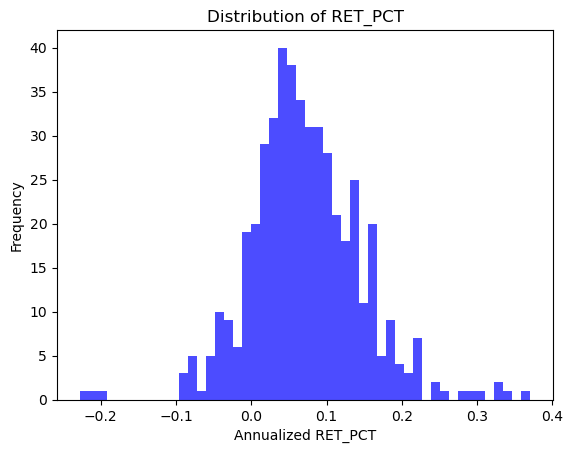

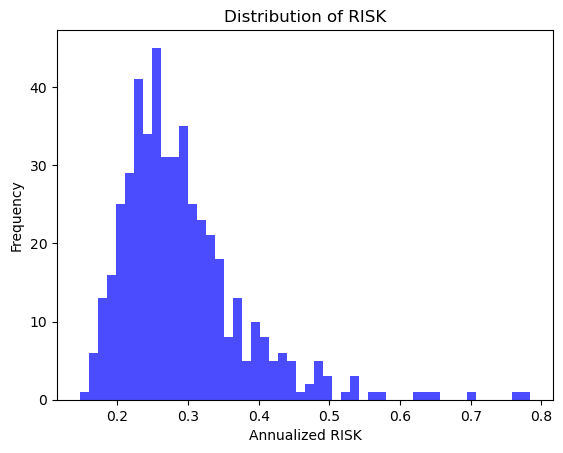

In [21]:
#plot an histogram of the average monthly return and the risk
for i in ['RET_PCT', 'RISK']:
    plt.hist(annualized_returns[i], bins=50, color='blue', alpha=0.7)
    plt.xlabel('Annualized ' + i)
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + i)
    plt.show()

In [22]:
correlation = annualized_returns[['RET_PCT', 'RISK']].corr().iloc[0, 1]
print('Correlation between annualized returns and risk:', correlation)

Correlation between annualized returns and risk: 0.14045984838465098


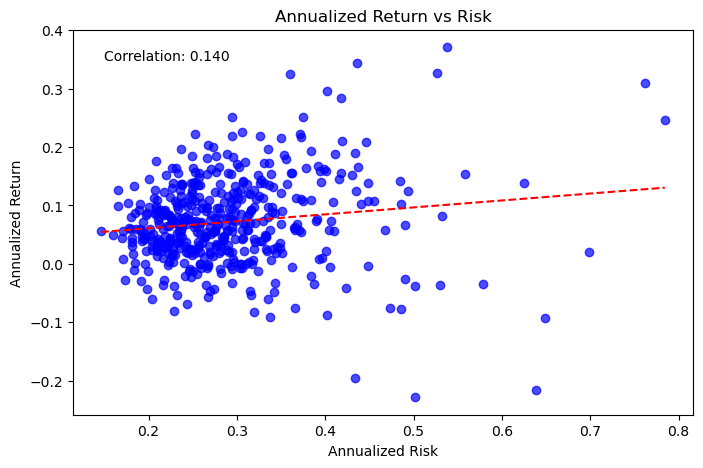

In [23]:
plt.figure(figsize=(8, 5))
plt.scatter(annualized_returns['RISK'], annualized_returns['RET_PCT'], color='blue', alpha=0.7)
plt.xlabel('Annualized Risk')
plt.ylabel('Annualized Return')
plt.title('Annualized Return vs Risk')

# Compute correlation
corr = annualized_returns['RISK'].corr(annualized_returns['RET_PCT'])

# Add a trendline
slope, intercept = np.polyfit(annualized_returns['RISK'], annualized_returns['RET_PCT'], 1)
x = np.linspace(annualized_returns['RISK'].min(), annualized_returns['RISK'].max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', linestyle='--', label='Trendline')

# Display correlation on the plot
plt.text(
    0.05, 0.95,
    f'Correlation: {corr:.3f}',
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top'
)

plt.show()